In [ ]:
# Topics List
# Ranking
# Cumulative Sum -> sales data
# Cumulative Average
# Running Average
# Percent of total

# Percent Change -> stocks data
# Percentage change for a specific window -> stocks data
# Quantiles/Percentiles - percentile_disc ->
# PERCENTILE_CONT
# Segmentation
# Cumulative Distribution
# Partition By Multiple Columns

## DataSet: Northwind

## Problem 1-4 : NorthWinddatset https://relational.fit.cvut.cz/dataset/Northwind

How to download the dataset

To download the dataset you need to create connection in your mysql workbench

The datasets are publicly available directly from MariaDB database.

* Open your favourite MariaDB client (MySQL Workbench)
Use following credentials:
```
    hostname: relational.fit.cvut.cz
    port: 3306
    username: guest
    password: relational
```
Drive link: https://drive.google.com/drive/folders/1FMi6g1KDHbn17ikJSi7bE9-THywlxhdu?usp=sharing

###`Q-1`: Rank Employee in terms of revenue generation. Show employee id, first name, revenue, and rank

```sql
select e.EmployeeID, e.FirstName , sum(od.UnitPrice * od.Quantity) as revenue,
rank() over( order by sum(od.UnitPrice * od.Quantity) desc) as EmpRank
from Orders o join `Order Details` od on od.OrderID = o.OrderID
join Employees e on e.EmployeeID = o.EmployeeID
group by e.EmployeeID, e.FirstName
order by EmpRank;
```

###`Q-2`: Show All products cumulative sum of units sold each month.


```sql
select p.ProductID, month(o.OrderDate) 'Month', sum(od.Quantity)  as 'QuantitySum',
sum(sum(od.Quantity)) over(partition by p.ProductID order by month(o.OrderDate) rows between unbounded preceding and current row) as QuantityCumSum
from Orders o join `Order Details` od on od.OrderID = o.OrderID
join Products p on p.ProductID = od.ProductID
group by p.ProductID, month(o.OrderDate);
```

###`Q-3`: Show Percentage of total revenue by each suppliers


```sql
select s.SupplierId, sum(od.UnitPrice*od.Quantity) as Revenue, sum(od.UnitPrice*od.Quantity) /
sum(sum(od.UnitPrice*od.Quantity)) over() * 100 as PercentTotalRevenue
from Suppliers s join Products p on p.SupplierId=s.SupplierID
join `Order Details` od on p.ProductID=od.ProductID
group by s.SupplierId
order by Revenue desc;
```

###`Q-4:` Show Percentage of total orders by each suppliers

```sql
select s.SupplierId, count(distinct od.OrderID) as NumberOfOrder, count(distinct od.OrderID) /
sum(count(distinct od.OrderID)) over() * 100 as PercentTotalOrder
from Suppliers s join Products p on p.SupplierId=s.SupplierID
join `Order Details` od on p.ProductID=od.ProductID
group by s.SupplierId
order by NumberOfOrder desc;
```

### `Q-5`:Show All Products Year Wise report of totalQuantity sold, percentage change from last year.

```sql
select *, 100 *(Quantity - lag(Quantity) over(partition  by ProductId order by ProductId, Year))/lag(Quantity) over(partition  by ProductId order by ProductId, Year) PercentageChange
from (select p.ProductID, year(o.OrderDate) Year, sum( od.Quantity)  as 'Quantity'
from Orders o join `Order Details` od on od.OrderID = o.OrderID
join Products p on p.ProductID = od.ProductID
group by p.ProductID,year(o.OrderDate)
order by p.ProductID,year(o.OrderDate)) t
```

## Problem 6 - 15

For the next problems, you can get the dataset as well as the details [here](https://www.kaggle.com/datasets/thedevastator/drug-performance-evaluation?select=Drug_clean.csv) (Use the *cleaned* csv file).

### **`Problem-6:`** For each condition, what is the average satisfaction level of drugs that are "On Label" vs "Off Label"?

```sql
-- Solution

WITH temp_df AS (
        SELECT
            drugs.Condition,
            drugs.Indication,
            drugs.Satisfaction,
            ROUND(
                AVG(drugs.Satisfaction) OVER(
                    PARTITION BY drugs.Condition,
                    drugs.Indication
                    ORDER BY drugs.Satisfaction
                    ROWS BETWEEN UNBOUNDED PRECEDING
                        AND UNBOUNDED FOLLOWING
                ),
                2
            ) AS avg_satisfaction,
            DENSE_RANK() OVER(
                PARTITION BY drugs.Condition,
                drugs.Indication
                ORDER BY
                    drugs.Satisfaction
            ) AS rank_num
        FROM drugs
    )
SELECT
    temp_df.Condition,
    temp_df.Indication,
    temp_df.avg_satisfaction
FROM temp_df
where rank_num = 1;
```

### **`Problem-7:`** For each drug type (RX, OTC, RX/OTC), what is the average ease of use and satisfaction level of drugs with a price above the median for their type?

```sql
-- Solution

WITH temp_df as (
    SELECT Type,
        AVG(EaseOfUse) OVER(PARTITION BY Type) AS avg_ease_of_use,
        AVG(Satisfaction) OVER(PARTITION BY Type) AS avg_satisfaction
    FROM (
        SELECT
            Type, Price,
            PERCENTILE_CONT(0.5) WITHIN GROUP (
                ORDER BY Price
            ) OVER (PARTITION BY Type) AS median_price,
            EaseOfUse,
            Satisfaction
        FROM drugs WHERE Type IN ('RX', 'OTC', 'RX/OTC')
    ) AS subquery
    WHERE Price >= median_price
)

SELECT Type, avg_ease_of_use, avg_satisfaction FROM temp_df GROUP BY Type;
```

### **`Problem 8:`** What is the cumulative distribution of EaseOfUse ratings for each drug type (RX, OTC, RX/OTC)? Show the results in descending order by drug type and cumulative distribution. (Use the built-in method and the manual method by calculating on your own.)

```sql
-- Solution

SELECT Type, EaseOfUse,
       COUNT(*) OVER (
            PARTITION BY Type
            ORDER BY EaseOfUse
        ) * 1.0 / COUNT(*) OVER (PARTITION BY Type) AS cumulative_dist_manual,
        cume_dist() over(
            partition by Type
            order by EaseOfUse
        ) as 'cumulative_dist_builtin'
FROM drugs
WHERE Type IN ('RX', 'OTC', 'RX/OTC')
ORDER BY Type, cumulative_dist DESC;
```


Few rows of result:

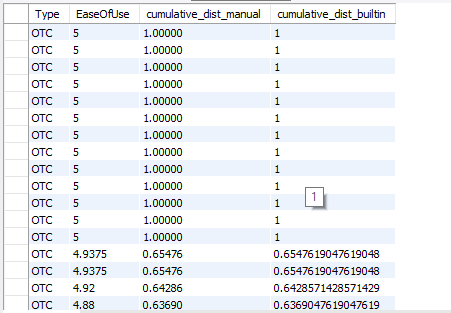

### **`Problem 9:`** What is the median satisfaction level for each medical condition? Show the results in descending order by median satisfaction level. (Don't repeat the same rows of your result.)

```sql
-- Solution

WITH temp_df AS (
    SELECT drugs.Condition,
       PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY drugs.Satisfaction) OVER (PARTITION BY drugs.Condition) AS median_satisfaction
    FROM drugs
)

SELECT temp_df.Condition, temp_df.median_satisfaction
FROM temp_df
GROUP BY temp_df.Condition
ORDER BY temp_df.median_satisfaction DESC;
```

### **`Problem 10:`** What is the running average of the price of drugs for each medical condition? Show the results in ascending order by medical condition and drug name.

```sql
-- Solution

SELECT drugs.Condition, drugs.Drug, ROUND(drugs.Price, 2),
    ROUND(AVG(drugs.Price) OVER (
        PARTITION BY drugs.Condition
        ORDER BY drugs.Drug
        ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
    ), 2) AS running_avg_price
FROM drugs
ORDER BY drugs.Condition ASC, drugs.Drug ASC;
```

### **`Problem 11:`** What is the percentage change in the number of reviews for each drug between the previous row and the current row? Show the results in descending order by percentage change.

```sql
-- Solution

SELECT drugs.Condition, drugs.Drug, drugs.Reviews,
    (drugs.Reviews - LAG(drugs.Reviews) OVER (
        PARTITION BY drugs.Condition, drugs.Drug
        ORDER BY drugs.Reviews DESC)
    ) * 100.0 / LAG(drugs.Reviews) OVER (
        PARTITION BY drugs.Condition, drugs.Drug
        ORDER BY drugs.Reviews DESC
    ) AS pct_change
FROM drugs
ORDER BY pct_change DESC;
```

### **`Problem 12:`** What is the percentage of total satisfaction level for each drug type (RX, OTC, RX/OTC)? Show the results in descending order by drug type and percentage of total satisfaction.

```sql
-- Solution

WITH temp_df AS (
    SELECT Type, Satisfaction,
        ROUND(SUM(Satisfaction) OVER (PARTITION BY Type) * 100.0 / SUM(Satisfaction) OVER (),2) AS pct_total_satisfaction
    FROM drugs
    WHERE Type IN ('RX', 'OTC', 'RX/OTC')
    ORDER BY Type ASC, pct_total_satisfaction DESC
)

SELECT Type, pct_total_satisfaction FROM temp_df
GROUP BY Type;
```

### **`Problem 13:`** What is the cumulative sum of effective ratings for each medical condition and drug form combination? Show the results in ascending order by medical condition, drug form and the name of the drug.

```sql
-- Solution

SELECT drugs.Condition, drugs.Form, drugs.Drug,
    drugs.Effective,
    SUM(drugs.Effective) OVER (
        PARTITION BY drugs.Condition, drugs.Form
        ORDER BY drugs.Drug
        ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
    ) AS cumulative_sum_effective
FROM drugs
ORDER BY
    drugs.Condition ASC,
    drugs.Form ASC,
    drugs.Drug ASC;
```

### **`Problem-14:`** What is the rank of the average ease of use for each drug type (RX, OTC, RX/OTC)? Show the results in descending order by rank and drug type.

```sql
-- Solution

SELECT
  Type,
  AVG(EaseOfUse) AS average_ease_of_use,
  RANK() OVER (ORDER BY AVG(EaseOfUse) DESC) AS 'rank'
FROM drugs
WHERE Type IN ('RX', 'OTC', 'RX/OTC')
GROUP BY Type;
```

### **`Problem-15:`** For each condition, what is the average effectiveness of the top 3 most reviewed drugs?

```sql
-- Solution

SELECT * FROM (
    SELECT
        drugs.Condition,
        drugs.Drug,
        ROUND(drugs.Reviews, 2) AS 'Reviews',
        ROUND(AVG(drugs.Effective) OVER (
            PARTITION BY drugs.Condition, drugs.Drug
            ORDER BY drugs.Reviews DESC
            ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING
        ), 2) AS avg_effectiveness,
    RANK() OVER (
        PARTITION BY drugs.Condition
        ORDER BY drugs.Reviews DESC
    ) AS rank_num
    FROM drugs
) t
WHERE rank_num <= 3;
```

```sql

-- Alternate Solution

SELECT
  ranked_drugs.Condition,
  drug,
  avg_effectiveness,
  `rank`
FROM (
  SELECT
    drugs.Condition,
    Drug,
    AVG(Effective) avg_effectiveness,
    ROW_NUMBER() OVER (PARTITION BY drugs.Condition ORDER BY SUM(Reviews) DESC) AS 'rank'
  FROM drugs
  GROUP BY drugs.Condition, Drug
) ranked_drugs
WHERE `rank` <= 3
order by ranked_drugs.Condition, `rank`;

```